In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.metrics import *
from scipy.ndimage import interpolation
import time

In [4]:
%%time
mnist = fetch_openml("mnist_784")

CPU times: user 25.9 s, sys: 860 ms, total: 26.8 s
Wall time: 27.8 s


In [4]:
mnist.data.shape

(70000, 784)

In [5]:
mnist.target.shape

(70000,)

In [7]:
images = mnist.data
targets = mnist.target
labels = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
target_name = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [ ]:
def moments(image):
    c0,c1 = np.mgrid[:image.shape[0],:image.shape[1]] # A trick in numPy to create a mesh grid
    totalImage = np.sum(image) #sum of pixels
    m0 = np.sum(c0*image)/totalImage #mu_x
    m1 = np.sum(c1*image)/totalImage #mu_y
    m00 = np.sum((c0-m0)**2*image)/totalImage #var(x)
    m11 = np.sum((c1-m1)**2*image)/totalImage #var(y)
    m01 = np.sum((c0-m0)*(c1-m1)*image)/totalImage #covariance(x,y)
    mu_vector = np.array([m0,m1]) # Notice that these are \mu_x, \mu_y respectively
    covariance_matrix = np.array([[m00,m01],[m01,m11]]) # Do you see a similarity between the covariance matrix
    return mu_vector, covariance_matrix

def deskew(image):
    c,v = moments(image)
    alpha = v[0,1]/v[0,0]
    affine = np.array([[1,0],[alpha,1]])
    ocenter = np.array(image.shape)/2.0
    offset = c-np.dot(affine,ocenter)
    img = interpolation.affine_transform(image,affine,offset=offset)
    return (img - img.min()) / (img.max() - img.min())

In [ ]:
# deskewed=[deskew(img) for img in trT[1]]
# deskewedTr=np.array(deskewed)
# print(deskewedTr.shape)

In [11]:
# stratify sampling
def sampling(X, y, test_size=0.3, do_stratify=True):
    if do_stratify:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=123, stratify=y)
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=123, stratify=None)
    
    # scaler
    sclaer = StandardScaler() # mean: 0, std: 1
    # scaler = MinMaxScaler() # max: 1, min: 0
    # scaler = RobustScaler() # median : 0, IQR : 1
    scaler.fit(X_train)
    scaler.fit(y_train)
    
    X_train = scaler.transform(X_train)
    y_train = scaler.transform(y_train)
    
    X_test = scaler.transform(X_test)
    y_test = scaler.transform(y_test)
    
    return X_train, X_test, y_train, y_test

In [13]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(49000, 784) (21000, 784)
(49000,) (21000,)


In [12]:
def count_target(target):
    for i in range(10):
        unique, counts = np.unique(target, return_counts=True)
        
    return counts

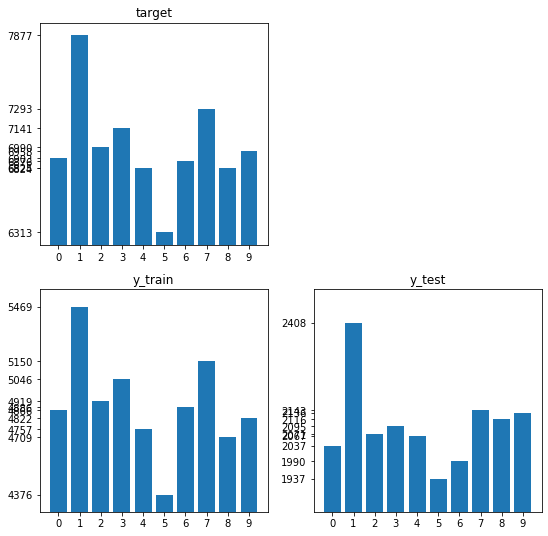

In [14]:
# distribution of numbers after stratify sampling
count_y_train = count_target(y_train)
count_y_test = count_target(y_test)
count_y = count_target(targets)

plt.figure(figsize=(9,9))

plt.subplot(221)
plt.bar(labels, count_y)
plt.title("target")
plt.xticks(labels, labels)
plt.yticks(count_y)
plt.ylim(min(count_y)-100, max(count_y)+100)

plt.subplot(223)
plt.bar(labels, count_y_train)
plt.title("y_train")
plt.xticks(labels, labels)
plt.yticks(count_y_train)
plt.ylim(min(count_y_train)-100, max(count_y_train)+100)

plt.subplot(224)
plt.bar(labels, count_y_test)
plt.title("y_test")
plt.xticks(labels, labels)
plt.yticks(count_y_test)
plt.ylim(min(count_y_test)-100, max(count_y_test)+100)

plt.show()

# SVM - linear kernel

In [17]:
C = [1000.0, 100.0, 10.0, 1.0, 0.1, 0.01, 0.001]

In [19]:
def run_gridsearchcv(X_train, y_train, C):
    """
    SVC : C-Support Vector Classification.
    GridSearchCV : Exhaustive search over specified parameter values for an estimator
                   estimator : SVM Classifier
                   parameters : linear kernel, C
                   scoring : f1
                   cross-validation : 10 times
    """
    
    parameters = {'kernel':['linear'], 'C':C}
    
    svc = SVC()
    clf = GridSearchCV(estimator=svc, param_grid=parameters, scoring='f1', cv=10, n_jobs=-1)
    # training
    start_time = time.time()
    %time clf.fit(X_train, y_train)
    end_time = time.time()

    best_param = clf.best_params_
    best_score = clf.best_score_
    
    print(clf.cv_results_["cv_validation_scores"]) # every result of cross-validation
    print(clf.cv_results_["mean_test_score"]) # mean of result of cross-validation
    print(best_param " : \n", best_score)
    
    with open("./results/train.txt", "a") as f:
        data = "training time : " + str(end_time-start_time) + "\n"
        data += "cv_validation_scores\n" + "="*10 + "n" + str(clf.cv_results_["cv_validation_scores"]) + "\n"
        data += "mean_test_score\n" + "="*10 + "n" + str(clf.cv_results_["mean_test_score"]) + "\n"
        data += "\nbest_param : " + str(best_param) + "\tbest_score : " + str(best_score)
        f.write(data)
    

    return best_param

In [ ]:
def diff_run_time(X_train, y_train, C):
    print("C is %f" %C)
    
    start_time = time.time()
    %time clf = SVC(kernel="linear", C=C).fix(X_train, y_train)
    end_time = time.time()
    
    with open("./results/diff_run_time.txt", "a") as f:
        data = "C is" + str(C) + "\nrunning time : " + str(end_time-start_time) + "\n"
        f.write(data)

In [ ]:
def test(X_train, X_test, y_train, y_test, C, target_name):
    clf = SVC(kernel="linear", C=C).fit(X_train, y_train)
    %time y_pred = clf.predict(X_test)
    
    cv_report = classification_report(y_test, y_pred, target_name=target_name)
    print(cv_report)
    
    res_SVM = []
    res_SVM.append([accuracy_score(y_test, y_pred),
              precision_score(y_test, y_pred, average="macro"),
              recall_score(y_test, y_pred, average="macro"),
              f1_score(y_test, y_pred, average="macro")])
    
    pd.DataFrame(res_SVM, columns = ["Accuracy", "Precision", "Recall", "F1-score"], index=["SVM"])
    
    cmat = confustion_matrix(y_test, y_pred, target_name)
    sns.set_palette("husl")
    plt.figure(figsize=(12,6))
    sns.heatmap(cmat, annot=True)
    
    with open("./results/test_cv_report.txt", "a") as f:
        data = "classification report : \n" + str(cv_report)
        data += str(res_SVM[i] for i in range(4))
        f.write(data)

In [ ]:
X_train, X_test, y_train, y_test = sampling(images, targets, 0.3, True)

In [ ]:
%%time
param = run_gridsearchcv(X_train, y_train, sorted(C, reverse=True))

In [ ]:
param

In [ ]:
# DO NOT UNCOMMENT!!
# test(X_train, X_test, y_train, y_test, param, target_name)